<a href="https://colab.research.google.com/github/Kecheng-Chen/CS194-26/blob/master/prob2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import packages
from __future__ import print_function, division
import os
import random
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, root_dir, length, transform=None, transform2=None):
        self.root_dir = root_dir
        self.length=length
        self.transform = transform
        self.transform2 = transform2

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx//6+1 in [8,12,14,15,22,30,35]:
          gender = 'f'
        else:
          gender = 'm'
        img_name = os.path.join(self.root_dir,'{:02d}-{:d}{}.jpg'.format(idx//6+1,idx%6+1,gender))
        image = io.imread(img_name)
        file = open(self.root_dir + '{:02d}-{:d}{}.asf'.format(idx//6+1,idx%6+1,gender))
        points = file.readlines()[16:74]
        landmarks = []
        for point in points:
          x,y = point.split('\t')[2:4]
          landmarks.append([float(x), float(y)])
        sample = {'image': image, 'landmarks': np.array(landmarks).astype('float32')}

        if self.transform:
            sample = self.transform(sample)

        if self.transform2:
            sample['image'] = self.transform2(sample['image'])

        image = rgb2gray(sample['image'])
        image = image.astype('float32')-0.5
        sample['image'] = torch.from_numpy(image)
        return sample

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(image.shape[1]*landmarks[:,0], image.shape[0]*landmarks[:,1], marker='.', c='r')
    plt.pause(0.001)

In [ ]:
class Rescale(object):

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        img = transform.resize(image, (self.output_size[0], \
                    self.output_size[1]))
        
        return {'image': img, 'landmarks': landmarks}


class Rotate(object):

    def __init__(self, max_angle):
        self.max_angle=max_angle

    def __call__(self, sample):
        seq = iaa.Sequential([iaa.Affine(rotate=(random.uniform(0,1)-0.5)*2*self.max_angle)])
        image, landmarks = sample['image'], sample['landmarks']
        landmarks[:,0] = image.shape[1]*landmarks[:,0]
        landmarks[:,1] = image.shape[0]*landmarks[:,1]
        kps = []
        for i in range(landmarks.shape[0]):
          kps.append(Keypoint(x=landmarks[i,0], y=landmarks[i,1]))
        kps = KeypointsOnImage(kps, shape=image.shape)
        image_aug, kps_aug = seq(image=image, keypoints=kps)
        for i in range(landmarks.shape[0]):
          landmarks[i,0]=kps_aug.keypoints[i].x/image.shape[1]
          landmarks[i,1]=kps_aug.keypoints[i].y/image.shape[0]
        return {'image': image_aug, 'landmarks': landmarks}


class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [ ]:
composed = transforms.Compose([Rescale((120,160)),Rotate(15),ToTensor()])
composed2 = transforms.Compose([transforms.ColorJitter(brightness=0.5)])
face_dataset = FaceLandmarksDataset(root_dir='/content/drive/My Drive/imm_face_db/',\
                  length=240,transform=composed, transform2=composed2)

60 torch.Size([120, 160]) torch.Size([58, 2])


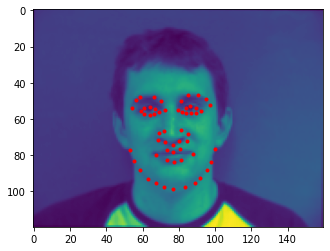

In [ ]:
fig = plt.figure()
i=60
sample = face_dataset[i]
print(i, sample['image'].shape, sample['landmarks'].shape)
show_landmarks(**sample)

In [ ]:
dataloader = DataLoader(face_dataset, batch_size=1, shuffle=False, num_workers=2)

0 torch.Size([1, 120, 160]) torch.Size([1, 58, 2])
1 torch.Size([1, 120, 160]) torch.Size([1, 58, 2])


<Figure size 432x288 with 0 Axes>

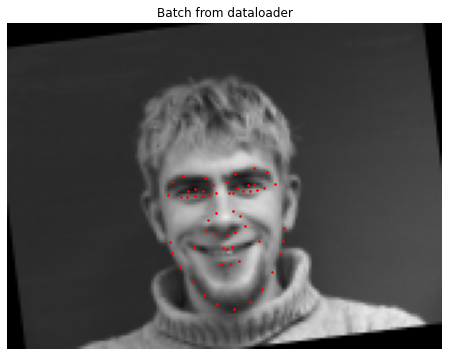

In [ ]:
def show_landmarks_batch(sample_batched):
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2
    grid = utils.make_grid(images_batch.unsqueeze(1))
    fig = plt.figure(figsize=(8,6))
    plt.imshow(grid.numpy().transpose((1, 2, 0))+0.5)
    plt.scatter(landmarks_batch[0,:,0].numpy()*images_batch.shape[2],
                    landmarks_batch[0,:,1].numpy()*images_batch.shape[1],
                    s=10, marker='.', c='r')
    plt.title('Batch from dataloader')
    #for i in range(batch_size):
        #plt.scatter(landmarks_batch[i,0].numpy()*70 + i * im_size + (i + 1) * grid_border_size,
                    #landmarks_batch[i,1].numpy()*54 + grid_border_size,
                    #s=10, marker='.', c='r')

        #plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 1:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 7)
        self.conv2 = nn.Conv2d(12, 16, 6)
        self.conv3 = nn.Conv2d(16, 20, 5)
        self.conv4 = nn.Conv2d(20, 24, 4)
        self.conv5 = nn.Conv2d(24, 28, 3)
        self.fc1 = nn.Linear(28*6*11, 400)
        self.fc2 = nn.Linear(400, 58*2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net().float()
print(net)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(6, 6), stride=(1, 1))
  (conv3): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(20, 24, kernel_size=(4, 4), stride=(1, 1))
  (conv5): Conv2d(24, 28, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1848, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=116, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
final=np.zeros((25,2))
for epoch in range(25):  # loop over the dataset multiple times

    running_loss = 0.0
    valid_loss = 0.0
    for i, data in enumerate(dataloader):
      if i<192:
        inputs, labels = \
            data['image'], data['landmarks']
        # zero the parameter gradients
        optimizer.zero_grad()
        
        outputs = net(inputs.unsqueeze(1).float())
        loss = criterion(outputs.view(-1,58,2), labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
      else:
        inputs, labels = \
            data['image'], data['landmarks']
        outputs = net(inputs.unsqueeze(1).float())
        loss = criterion(outputs.view(-1,58,2), labels)
        valid_loss += loss.item()
    final[epoch,0]=running_loss/192
    final[epoch,1]=valid_loss/48
print('Finished Training')

Finished Training


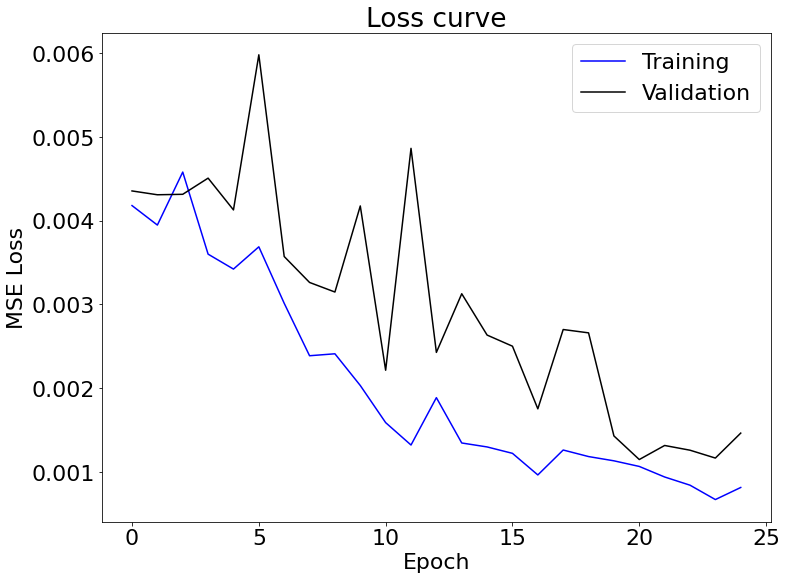

In [ ]:
t1 = np.arange(0.0, 25.0, 1.0)
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(12,9))
plt.plot(t1, final[:,0], 'b', t1, final[:,1], 'k')
plt.legend(['Training', 'Validation'])
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Loss curve')
plt.show()

In [ ]:
PATH = '/content/drive/My Drive/prob2_25epoch.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

221 torch.Size([120, 160]) torch.Size([58, 2])


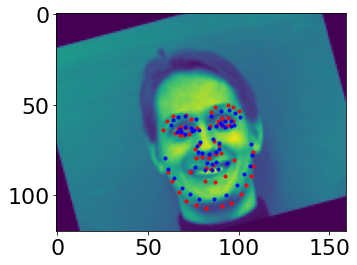

In [ ]:
fig = plt.figure()
i=221
sample = face_dataset[i]
print(i, sample['image'].shape, sample['landmarks'].shape)
image=sample['image']
landmarks=sample['landmarks']
outputs = net(image.unsqueeze(0).unsqueeze(0).float())
outputs = outputs.view(-1,58,2)
plt.imshow(image)
plt.scatter(image.shape[1]*landmarks[:,0], image.shape[0]*landmarks[:,1], marker='.', c='r')
plt.scatter(image.shape[1]*outputs.detach().numpy()[0,:,0], image.shape[0]*outputs.detach().numpy()[0,:,1], marker='.', c='b')
plt.pause(0.001)

In [ ]:
for layer in net.state_dict():
	# check for convolutional layer
	print(layer)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
conv4.weight
conv4.bias
conv5.weight
conv5.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


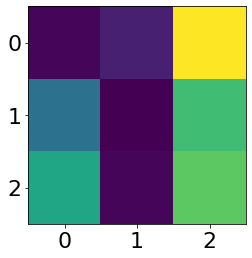

In [ ]:
plt.imshow(net.state_dict()['conv5.weight'][8].numpy()[2,:,:])

In [ ]:
net.state_dict()['fc1.weight'].shape

torch.Size([400, 1848])